## Description

In this notebook, we analyze the segmentation results.  

In [2]:
%matplotlib notebook

In [3]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import pandas as pd
from sklearn.cluster import KMeans
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra, total_spectrum

In [4]:
import numpy.random as rd

In [5]:
analyzed_mass_range = (600, 1000)

In [6]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [7]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [8]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [9]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [10]:
lipid_formulas = {n : [] for n in image_names}
for i, n in enumerate(image_names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            lipid_formulas[n].append(l[0])
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 84 formulas for cerebellum
Loaded 43 formulas for bladder


In [11]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

Load the quantification results. Note: contrary to previous notebooks, we'll use 3D arrays to store the intensity data. The first two dimentions denote spatial coordinates, the third one is the lipid ID.  

In [12]:
masserstein_images = {n : np.zeros(image_shapes[n] + (len(lipid_spectra[n]), )) for n in image_names}
for n in image_names:
    loaded_forumlas = lipid_formulas[n]
    with open(n + '_masserstein_quantification.tsv') as h:
        header = next(h)
        header = header.strip().split('\t')
        header_formulas = header[2:]
        # assert correct sorting of the data columns
        assert header_formulas == loaded_forumlas 
        for l in h:
            l = l.strip().split('\t')
            ar_x, ar_y = int(l[0]), int(l[1])
            vec = list(map(float, l[2:]))
            masserstein_images[n][ar_x, ar_y, ...] = vec 

In [13]:
intensity_images = {n : np.zeros(image_shapes[n] + (len(lipid_spectra[n]), )) for n in image_names}
for n in image_names:
    loaded_forumlas = lipid_formulas[n]
    with open(n + '_single_peak_intensities.tsv') as h:
        header = next(h)
        header = header.strip().split('\t')
        header_formulas = header[2:]
        # assert correct sorting of the data columns
        assert header_formulas == loaded_forumlas 
        for l in h:
            l = l.strip().split('\t')
            ar_x, ar_y = int(l[0]), int(l[1])
            vec = list(map(float, l[2:]))
            intensity_images[n][ar_x, ar_y, ...] = vec 

Verify proper loading:

<IPython.core.display.Javascript object>


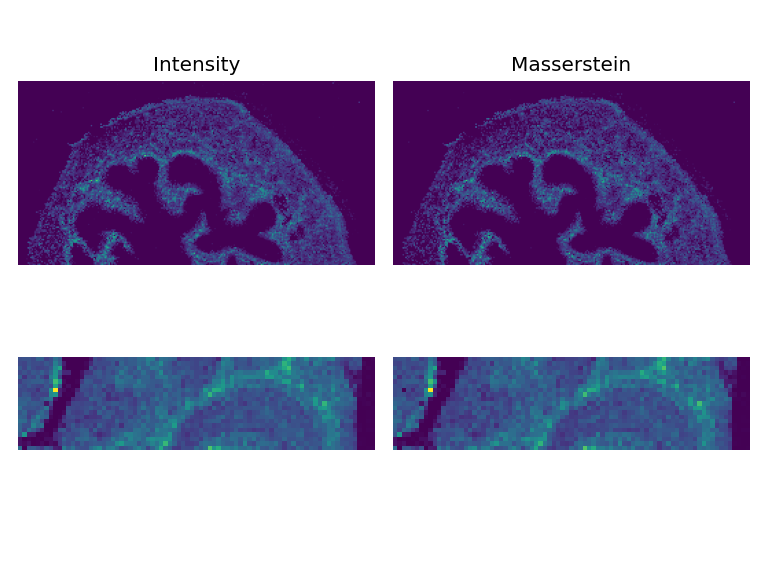

In [14]:
plt.figure()
plt.subplot(221)
plt.title('Intensity')
plt.imshow(intensity_images['bladder'][..., 3])
plt.axis('off')
plt.subplot(222)
plt.title('Masserstein')
plt.imshow(masserstein_images['bladder'][..., 3])
plt.axis('off')
plt.subplot(223)
plt.imshow(intensity_images['cerebellum'][..., 1])
plt.axis('off')
plt.subplot(224)
plt.imshow(masserstein_images['cerebellum'][..., 1])
plt.axis('off')
plt.tight_layout()
plt.show()

Load the segmentation results:

In [15]:
single_peak_kmeans_segmentation = {n : np.zeros(image_shapes[n] + (len(lipid_spectra[n]), ), dtype='int') for n in image_names}
for n in image_names:
    with open(n + '_kmeans.tsv') as h:
        header = next(h)
        header = header.strip().split('\t')
        for l in h:
            l = l.strip().split('\t')
            vec = list(map(float, l[2:]))
            ar_x, ar_y = int(l[0]), int(l[1])
            single_peak_kmeans_segmentation[n][ar_x, ar_y, ...] = vec 

In [16]:
masserstein_sdgmm_segmentation = {n : np.zeros(image_shapes[n] + (len(lipid_spectra[n]), ), dtype='int') for n in image_names}
for n in image_names:
    with open(n + '_sdgmm.tsv') as h:
        header = next(h)
        header = header.strip().split('\t')
        for l in h:
            l = l.strip().split('\t')
            vec = list(map(float, l[2:]))
            ar_x, ar_y = int(l[0]), int(l[1])
            masserstein_sdgmm_segmentation[n][ar_x, ar_y, ...] = vec 

Verify proper loading:

<IPython.core.display.Javascript object>


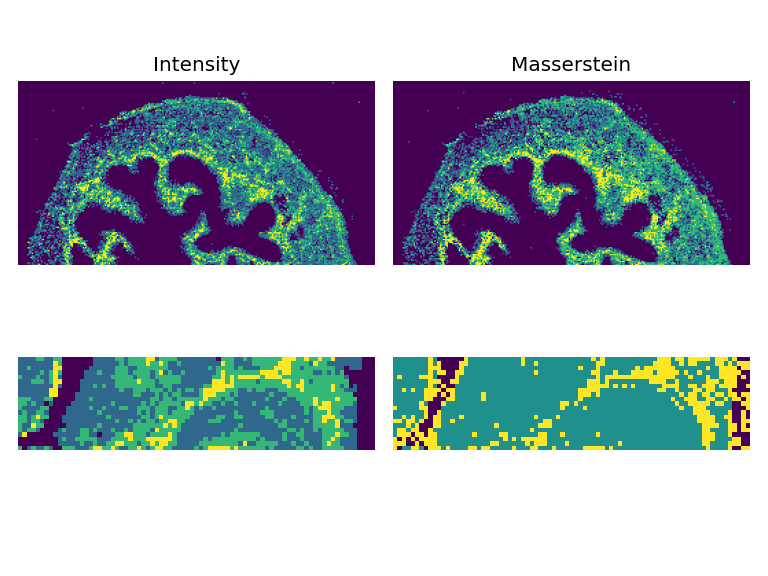

In [17]:
plt.figure()
plt.subplot(221)
plt.title('Intensity')
plt.imshow(single_peak_kmeans_segmentation['bladder'][..., 3])
plt.axis('off')
plt.subplot(222)
plt.title('Masserstein')
plt.imshow(masserstein_sdgmm_segmentation['bladder'][..., 3])
plt.axis('off')
plt.subplot(223)
plt.imshow(single_peak_kmeans_segmentation['cerebellum'][..., 1])
plt.axis('off')
plt.subplot(224)
plt.imshow(masserstein_sdgmm_segmentation['cerebellum'][..., 1])
plt.axis('off')
plt.tight_layout()
plt.show()

## Correlation between segmentation techniques

In [18]:
segmentation_agreement_percent = {n: np.zeros(len(lipid_formulas[n])) for n in image_names}
segmentation_kendall = {n: np.zeros(len(lipid_formulas[n])) for n in image_names}
for n in image_names:
    segmentation_agreement_percent[n] = np.mean(masserstein_sdgmm_segmentation[n] == single_peak_kmeans_segmentation[n], 
                                            axis=(0,1))  
    
    

Identity for cerebellum: 0.6233938019652305
Identity for bladder: 0.8666348490107602


<IPython.core.display.Javascript object>


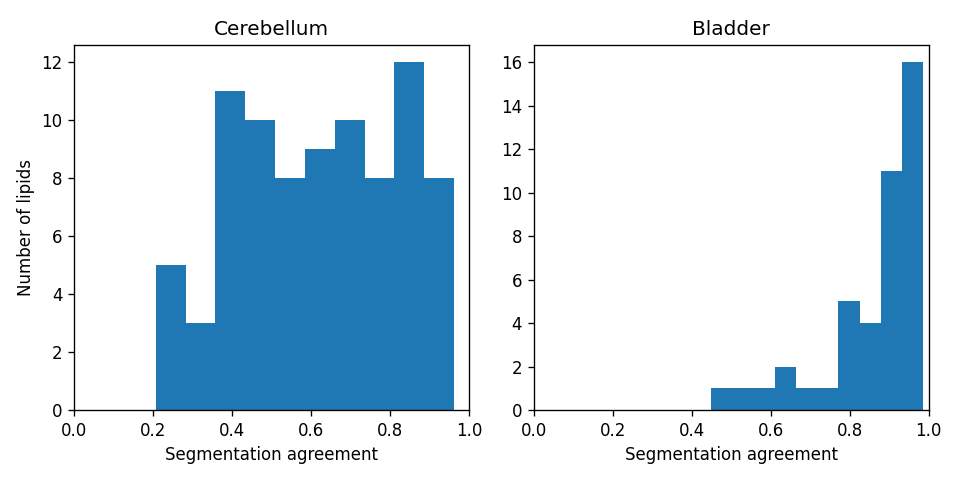

In [24]:
print('Identity for cerebellum:', np.mean(segmentation_agreement_percent['cerebellum']))
print('Identity for bladder:', np.mean(segmentation_agreement_percent['bladder']))
plt.figure(figsize=(8,4), dpi=100)
plt.subplot(121)
plt.title('Cerebellum')
plt.xlim(0,1)
plt.xlabel('Segmentation agreement')
plt.ylabel('Number of lipids')
plt.hist(segmentation_agreement_percent['cerebellum'])
plt.subplot(122)
plt.title('Bladder')
plt.xlim(0,1)
plt.xlabel('Segmentation agreement')
plt.hist(segmentation_agreement_percent['bladder'])
plt.tight_layout()

## Spatial consistency 

In [68]:
sdgmm_consistency_scores = {n: np.zeros(len(lipid_formulas[n])) for n in image_names}
kmeans_consistency_scores = {n: np.zeros(len(lipid_formulas[n])) for n in image_names}
for n in image_names:
    t = masserstein_sdgmm_segmentation[n]
    r = single_peak_kmeans_segmentation[n]
    for sh1 in [-1, 0, 1]:
        for sh2 in [-1, 0, 1]:
            if sh1 == 0 and sh2 == 0: continue
            sdgmm_consistency_scores[n] += np.sum(t == np.roll(t, (sh1, sh2), axis=(0, 1)), axis=(0, 1))
            kmeans_consistency_scores[n] += np.sum(r == np.roll(r, (sh1, sh2), axis=(0, 1)), axis=(0, 1))
    sdgmm_consistency_scores[n] /= (8*image_shapes[n][0]*image_shapes[n][1])
    kmeans_consistency_scores[n] /= (8*image_shapes[n][0]*image_shapes[n][1])

In [73]:
sdgmm_consistency_scores[n]

array([0.82141935, 0.89528559, 0.82900402, 0.72096728, 0.94791906,
       0.77005597, 0.90569747, 0.8595508 , 0.82496412, 0.68160878,
       0.88202497, 0.90508754, 0.72286165, 0.72055109, 0.73238375,
       0.90898393, 0.77021383, 0.91801808, 0.79746699, 0.83979621,
       0.65213117, 0.7785663 , 0.89375718, 0.87440442, 0.81488232,
       0.85414753, 0.93237658, 0.91224168, 0.90485075, 0.97296211,
       0.97708812, 0.77161309, 0.78615815, 0.98703358, 0.91256458,
       0.71779564, 0.82540901, 0.8144159 , 0.90358783, 0.93078358,
       0.94898823, 0.92653559, 0.81132319])

In [74]:
kmeans_consistency_scores[n]

array([0.80699627, 0.8094934 , 0.78417049, 0.71423651, 0.71283726,
       0.60246125, 0.85487227, 0.77253875, 0.78645235, 0.66354765,
       0.86204076, 0.88259185, 0.71803243, 0.72520092, 0.71084242,
       0.86381315, 0.72515069, 0.91387773, 0.74979908, 0.80213117,
       0.63127153, 0.68690442, 0.84761768, 0.85845293, 0.78140786,
       0.84363519, 0.92385907, 0.78657434, 0.898407  , 0.6181903 ,
       0.72516504, 0.75573335, 0.72115385, 0.72655712, 0.89982061,
       0.65964409, 0.80119834, 0.77001292, 0.8966992 , 0.85504449,
       0.94223594, 0.91955367, 0.72767652])

Note: consistency scores are not directly comparable due to masserstein changing the spatial distributions. So we shouldn't do this: 

In [72]:
100*(sdgmm_consistency_scores[n]/kmeans_consistency_scores[n] - 1)

array([ 1.78725447, 10.59825726,  5.7173185 ,  0.94237261, 32.97832718,
       27.8183399 ,  5.94535611, 11.2631315 ,  4.89689781,  2.72190501,
        2.31824463,  2.54882193,  0.67256283, -0.64117787,  3.0303948 ,
        5.22923053,  6.21431469,  0.4530536 ,  6.35742449,  4.69562106,
        3.30438539, 13.34419756,  5.44343233,  1.85816741,  4.28386457,
        1.24607677,  0.92194891, 15.97653649,  0.71724094, 57.38877088,
       34.74010232,  2.10123529,  9.01393035, 35.85078961,  1.41627924,
        8.81559481,  3.02180825,  5.76652471,  0.76822125,  8.85791254,
        0.71662478,  0.75927241, 11.49503496])

In [79]:
n='cerebellum'

<IPython.core.display.Javascript object>


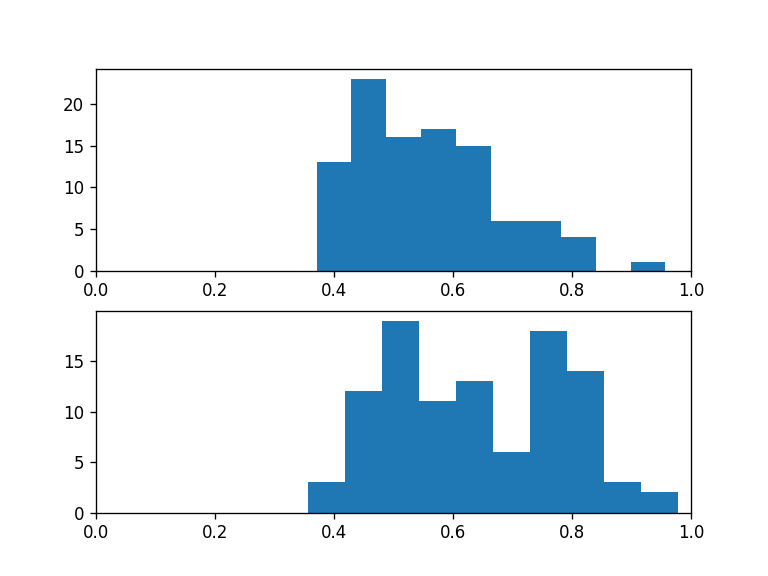

(0.0, 1.0)

In [80]:
plt.figure()
plt.subplot(211)
plt.xlim(0, 1)
plt.hist(kmeans_consistency_scores[n])
plt.subplot(212)
plt.hist(sdgmm_consistency_scores[n])
plt.xlim(0,1)

## Manual inspection of individual lipids

#### Cerebellum lipid nb 9

In [67]:
test_name = 'cerebellum'
test_lipid_id = 9  # 37, 69
test_intensity_image = intensity_images[test_name][..., test_lipid_id]
test_masserstein_image = masserstein_images[test_name][..., test_lipid_id]
test_lipid_spectrum = lipid_spectra[test_name][test_lipid_id]
test_lipid_spectrum = test_lipid_spectrum*(1/test_lipid_spectrum.confs[0][1])
test_lipid_mass = test_lipid_spectrum.confs[0][0]
test_mass_axis = np.arange(test_lipid_mass - 5,  test_lipid_mass+ 10, 0.001)
print('Selected lipid mass:', test_lipid_mass, 'formula:', lipid_spectra[test_name][test_lipid_id].formula)

Selected lipid mass: 741.4836628734499 formula: C39H75O8P


<IPython.core.display.Javascript object>


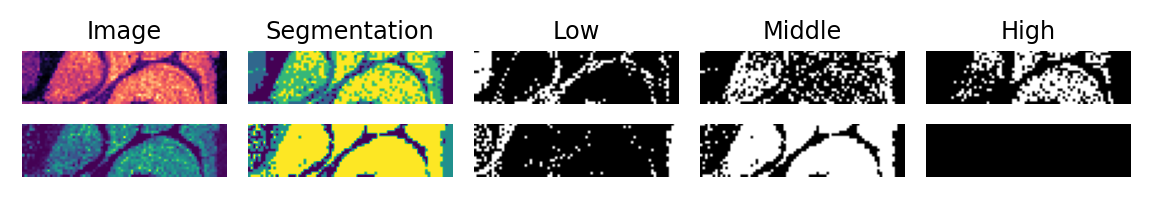

In [68]:
plt.figure(figsize=(8,1.5), dpi=120)
plt.subplot(2,5,1)
plt.title('Image')
plt.imshow(test_intensity_image, cmap=cm.magma)
plt.axis('off')

plt.subplot(2,5,2)
plt.title('Segmentation')
plt.imshow(single_peak_kmeans_segmentation[test_name][..., test_lipid_id])
plt.axis('off')

plt.subplot(2,5,3)
plt.title('Low')
plt.imshow(single_peak_kmeans_segmentation[test_name][..., test_lipid_id]==1, cmap=cm.gray)
plt.axis('off')

plt.subplot(2,5,4)
plt.title('Middle')
plt.imshow(single_peak_kmeans_segmentation[test_name][..., test_lipid_id]==2, cmap=cm.gray)
plt.axis('off')

plt.subplot(2,5,5)
plt.title('High')
plt.imshow(single_peak_kmeans_segmentation[test_name][..., test_lipid_id]==3, cmap=cm.gray)
plt.axis('off')


plt.subplot(2,5,6)
plt.imshow(test_masserstein_image)
plt.axis('off')

plt.subplot(2,5,7)
plt.imshow(masserstein_sdgmm_segmentation[test_name][..., test_lipid_id])
plt.axis('off')

plt.subplot(2,5,8)
plt.imshow(masserstein_sdgmm_segmentation[test_name][..., test_lipid_id]==1, cmap=cm.gray)
plt.axis('off')

plt.subplot(2,5,9)
plt.imshow(masserstein_sdgmm_segmentation[test_name][..., test_lipid_id]==2, cmap=cm.gray)
plt.axis('off')

plt.subplot(2,5,10)
plt.imshow(masserstein_sdgmm_segmentation[test_name][..., test_lipid_id]==3, cmap=cm.gray)
plt.axis('off')

plt.tight_layout()

ZROBIC I ZBADAC AVERAGE SPECTRUM

There is a noticeable peak shoulder at 785.56 in the masserstein-enriched region, which is absent in the masserstein-depleted region

Inspect the shoulder:

In [47]:
left_shoulder_image = profile_ion_image(profile_images[test_name], 784.569)
right_shoulder_image = profile_ion_image(profile_images[test_name], 784.589)
neighbor_image = profile_ion_image(profile_images[test_name], 784.526)

<IPython.core.display.Javascript object>


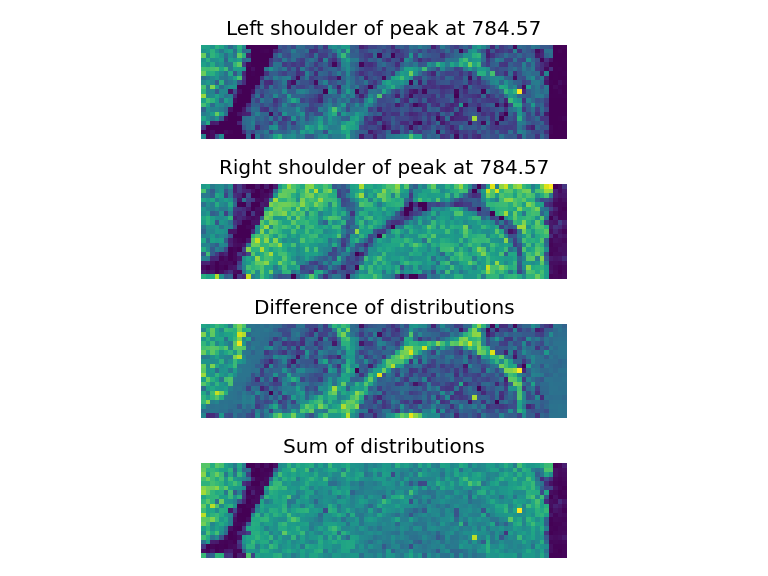

In [54]:
plt.figure()
plt.subplot(411)
plt.imshow(left_shoulder_image)
plt.axis('off')
plt.title('Left shoulder of peak at 784.57')
plt.subplot(412)
plt.imshow(right_shoulder_image)
plt.axis('off')
plt.title('Right shoulder of peak at 784.57')
plt.subplot(413)
plt.imshow(left_shoulder_image/np.sum(left_shoulder_image)-right_shoulder_image/np.sum(right_shoulder_image))
plt.axis('off')
plt.title('Difference of distributions')
plt.subplot(414)
plt.imshow(left_shoulder_image/np.sum(left_shoulder_image)+right_shoulder_image/np.sum(right_shoulder_image))
plt.axis('off')
plt.title('Sum of distributions')
plt.tight_layout()

Visible difference, confirming an overlap of peaks with different distributions.

Inspect the monoisotopic peak of the test lipid at the exact mz (corresponding to a left-side of the peak) and at the peak's observed apex

In [49]:
test_lipid_mono_exact_im = profile_ion_image(profile_images[test_name], 783.567)
test_lipid_mono_apex_im = profile_ion_image(profile_images[test_name], 783.571)

<IPython.core.display.Javascript object>


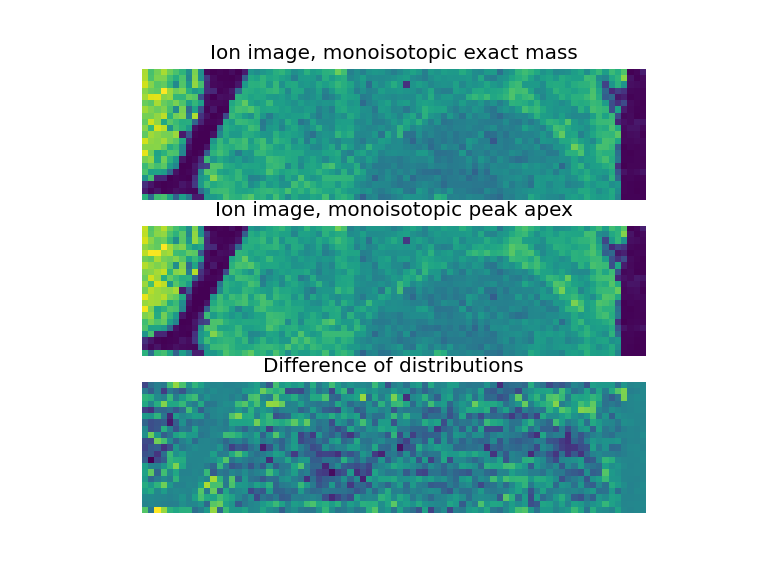

Text(0.5, 1.0, 'Difference of distributions')

In [50]:
plt.figure()
plt.subplot(311)
plt.imshow(test_lipid_mono_exact_im)
plt.axis('off')
plt.title('Ion image, monoisotopic exact mass')
plt.subplot(312)
plt.imshow(test_lipid_mono_apex_im)
plt.axis('off')
plt.title('Ion image, monoisotopic peak apex')
plt.subplot(313)
plt.imshow(test_lipid_mono_exact_im/np.sum(test_lipid_mono_exact_im)-test_lipid_mono_apex_im/np.sum(test_lipid_mono_apex_im))
plt.axis('off')
plt.title('Difference of distributions')

Inspect the monoisotopic peak of the test lipid and the interfering peak at -1 Da

In [51]:
interfering_peak_mass = 782.5679  # test_lipid_mass - 1
interfering_peak_image = profile_ion_image(profile_images[test_name], interfering_peak_mass)

<IPython.core.display.Javascript object>


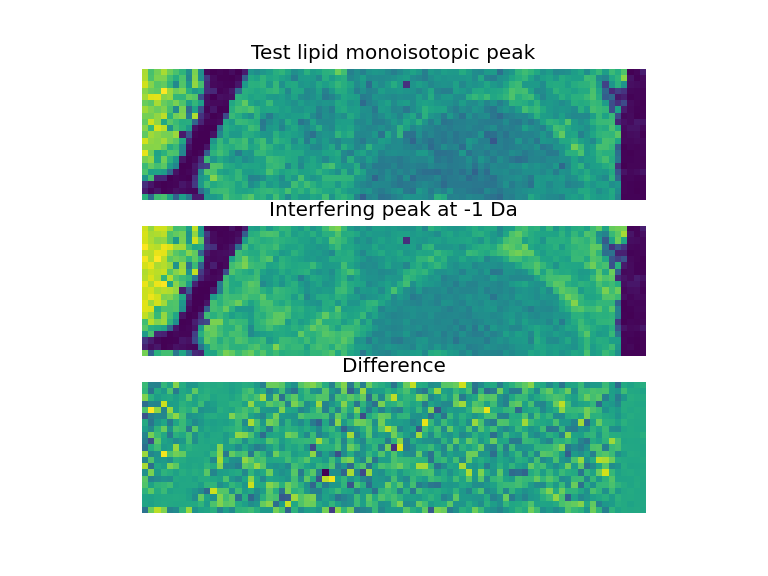

Text(0.5, 1.0, 'Difference')

In [52]:
plt.figure()
plt.subplot(311)
plt.imshow(test_lipid_mono_exact_im)
plt.axis('off')
plt.title('Test lipid monoisotopic peak')
plt.subplot(312)
plt.imshow(interfering_peak_image)
plt.axis('off')
plt.title('Interfering peak at -1 Da')
plt.subplot(313)
plt.imshow(test_lipid_mono_exact_im/np.sum(test_lipid_mono_exact_im)-interfering_peak_image/np.sum(interfering_peak_image))
plt.axis('off')
plt.title('Difference')

No clearly visible difference, perhaps due to signal overshadowing by the peak at -1 Da, which has a higher intensity and therefore a higher contribution to the appearance of the single ion image.  

Wniosek: jest git, nie potrzebujemy identyfikować interferencji, widzimy że się zgadza po pikach izotopowych i ich rozkładzie, ich wysokości są zgodne z enriched/depleted regions naszego lipidu, a rozkład dwóch wierzchołków piku izotopowego pokazuje że pik monoizotopowy to złożenie dwóch rozkładów. Piszemy po prostu że "unidentified interference".     

#### Cerebellum lipid nb 49

#### Bladder lipid nb 1

#### Bladder 

1 - dzieki massersteinie widzimy ze tylko w umbrella cells, nie w calym urothelium
 
35 - dzieki sdgmm widzimy ze jest w calym urothelium

42 - widzimy ze uniformly w miesniu i cienka warstwa laminy wokol urothelium, rowniez dzieki spatialdgmm

## Generating summary plots

Generate and save images with full data on segments: 

In [32]:
for image_id, n in enumerate(image_names):
    print(n)
    full_mass_axis = np.arange(600, 1000, 0.001)
    image_total_spectrum = total_spectrum(profile_images[n], full_mass_axis)
    image_total_spectrum = np.array(image_total_spectrum)
    for lipid_id, lipid_sp in enumerate(lipid_spectra[n][8:18]):
        lipid_id += 8
        print(lipid_id)
        # split peak intensities and masserstein estimates per segment
        single_peak_in_clusters = []
        masserstein_in_clusters = []
        for segment_id in range(1, 3):  # skipping the background cluster
            kmeans_segment_mask = single_peak_kmeans_segmentation[n][..., lipid_id]==segment_id
            sdgmm_segment_mask = masserstein_sdgmm_segmentation[n][..., lipid_id]==segment_id
            single_peak_in_clusters.append(intensity_images[n][kmeans_segment_mask, lipid_id])
            masserstein_in_clusters.append(masserstein_images[n][sdgmm_segment_mask, lipid_id])
        
        nbh_lbound = lipid_sp.confs[0][0] - 1.2
        nbh_ubound = lipid_sp.confs[0][0] + 2.2
        in_nbh = (full_mass_axis >= nbh_lbound)*(full_mass_axis<=nbh_ubound)
        local_mass_axis = full_mass_axis[in_nbh]
        local_total = image_total_spectrum[in_nbh]
        monoisotopic_total = local_total[np.searchsorted(local_mass_axis, lipid_sp.confs[0][0])]
        
        intensity_per_segment = []
        masserstein_per_segment = []
        for segment_id in range(3):
            intensity_per_segment.append(total_spectrum(profile_images[n], 
                                                        local_mass_axis, 
                                                        single_peak_kmeans_segmentation[n][..., lipid_id] == segment_id))
            masserstein_per_segment.append(total_spectrum(profile_images[n], 
                                                        local_mass_axis, 
                                                        masserstein_sdgmm_segmentation[n][..., lipid_id] == segment_id))
        intensity_per_segment = np.array(intensity_per_segment)
        masserstein_per_segment = np.array(masserstein_per_segment)
        #assert np.all(np.sum(intensity_per_segment, axis=0) == total)
        #assert np.all(np.sum(masserstein_per_segment, axis=0) == total)
        # intensity_cluster_spectra = segment_average_spectra(profile_images[n], single_peak_kmeans_segmentation[n][..., lipid_id], mass_axis)
        # masserstein_cluster_spectra = segment_average_spectra(profile_images[n], masserstein_sdgmm_segmentation[n][..., lipid_id], mass_axis)
        plt.figure(figsize=(7.6, 10), dpi=300)
        
        plt.subplot(4, 2, 1)
        plt.title('Peak (profile)\n' + str(round(lipid_sp.confs[0][0], 3)))
        plt.imshow(intensity_images[n][..., lipid_id])
        plt.axis('off')
        
        plt.subplot(4, 2, 2)
        plt.title('Masserstein\n' + lipid_sp.formula)
        plt.imshow(masserstein_images[n][..., lipid_id])
        plt.axis('off')
        
        plt.subplot(4, 2, 3)
        plt.title('K-means')
        plt.imshow(single_peak_kmeans_segmentation[n][..., lipid_id])
        plt.axis('off')
        
        plt.subplot(4, 2, 4)
        plt.title('sDGMM')
        plt.imshow(masserstein_sdgmm_segmentation[n][..., lipid_id])
        plt.axis('off')
        
        plt.subplot(4, 2, 5)
        plt.title('Peak intensity\nper cluster')
        plt.hist(single_peak_in_clusters, stacked=True, bins=80)
        
        plt.subplot(4, 2, 6)
        plt.title('Estimated signal\nper cluster')
        plt.hist(masserstein_in_clusters, stacked=True, bins=80)
        
        plt.subplot(4, 2, 7)
        plt.title('AV')
        plt.plot(local_mass_axis, local_total, lw=0.1, color='k', alpha=0.5)
        plt.annotate('', 
                     xy=(lipid_sp.confs[0][0], monoisotopic_total), 
                     xytext=(lipid_sp.confs[0][0]+0.5, monoisotopic_total+0.5),
                     arrowprops=dict(facecolor='black', width=2))
        for segment_id in range(3):
            plt.fill_between(local_mass_axis, 
                             np.sum(intensity_per_segment[:segment_id,], axis=0),
                             np.sum(intensity_per_segment[:(segment_id+1), ], axis=0),
                             alpha=0.8)
        
        plt.legend(['Total'] + ['Cluster %i' % cl_id for cl_id in range(3)])
        plt.xlim(nbh_lbound, nbh_ubound)
        
        plt.subplot(4, 2, 8)
        plt.plot(local_mass_axis, local_total, lw=0.1, color='k', alpha=0.5)
        (lipid_sp*(monoisotopic_total/lipid_sp.confs[0][1])).plot(show=False, lw=0.5, color='k', alpha=0.5)
        for segment_id in range(3):
            plt.fill_between(local_mass_axis, 
                             np.sum(masserstein_per_segment[:segment_id,], axis=0),
                             np.sum(masserstein_per_segment[:(segment_id+1), ], axis=0),
                             alpha=0.8)
        plt.legend(['Total'] + ['Cluster %i' % cl_id for cl_id in range(3)])
        plt.xlim(nbh_lbound, nbh_ubound)

        plt.tight_layout()
        plt.savefig('Figs/' + n + '_combined_results/%i.png' % lipid_id, dpi=600)
        plt.close()

cerebellum
8
9
10
11
12
13
14
15
16
17
bladder
8
9
10
11
12
13
14
15
16
17


Version with average spectra overlayed and normalized independently:

In [ ]:
# for image_id, n in enumerate(image_names):
#     intsy_matrix = single_peak_intensities[n]
#     decon_matrix = masserstein_estimation[n]
#     for lipid_id, lipid_sp in enumerate(lipid_spectra[n]):
#         # split peak intensities and masserstein estimates per segment
#         single_peak_in_clusters = []
#         masserstein_in_clusters = []
#         for segment_id in range(1, 3):  # skipping the background cluster
#             kmeans_segment_mask = single_peak_kmeans_segmentation[n][..., lipid_id]==segment_id
#             sdgmm_segment_mask = masserstein_sdgmm_segmentation[n][..., lipid_id]==segment_id
#             single_peak_in_clusters.append(intensity_images[n][kmeans_segment_mask, lipid_id])
#             masserstein_in_clusters.append(masserstein_images[n][sdgmm_segment_mask, lipid_id])
            
        
#         mass_axis = np.arange(lipid_sp.confs[0][0] - 1, lipid_sp.confs[0][0] + 3, step=0.001)
#         intensity_cluster_spectra = segment_average_spectra(profile_images[n], single_peak_kmeans_segmentation[n][..., lipid_id], mass_axis)
#         masserstein_cluster_spectra = segment_average_spectra(profile_images[n], masserstein_sdgmm_segmentation[n][..., lipid_id], mass_axis)
#         plt.figure(figsize=(7.6, 10), dpi=300)
        
#         plt.subplot(4, 2, 1)
#         plt.title('Peak (profile)\n' + str(round(lipid_sp.confs[0][0], 3)))
#         plt.imshow(intensity_images[n][..., lipid_id])
#         plt.axis('off')
        
#         plt.subplot(4, 2, 2)
#         plt.title('Masserstein\n' + lipid_sp.formula)
#         plt.imshow(masserstein_images[n][..., lipid_id])
#         plt.axis('off')
        
#         plt.subplot(4, 2, 3)
#         plt.title('K-means')
#         plt.imshow(single_peak_kmeans_segmentation[n][..., lipid_id])
#         plt.axis('off')
        
#         plt.subplot(4, 2, 4)
#         plt.title('sDGMM')
#         plt.imshow(masserstein_sdgmm_segmentation[n][..., lipid_id])
#         plt.axis('off')
        
#         plt.subplot(4, 2, 5)
#         plt.title('Peak intensity\nper cluster')
#         plt.hist(single_peak_in_clusters, stacked=True, bins=80)
        
#         plt.subplot(4, 2, 6)
#         plt.title('Estimated signal\nper cluster')
#         plt.hist(masserstein_in_clusters, stacked=True, bins=80)
        
#         plt.subplot(4, 2, 7)
#         plt.title('Average spectra of clusters')
#         for av_intsy in intensity_cluster_spectra:
#             plt.plot(mass_axis, av_intsy, alpha=0.5, lw=0.5)
#         plt.legend(['Cluster %i' % cl_id for cl_id in range(len(intensity_cluster_spectra))])
        
#         plt.subplot(4, 2, 8)
#         plt.title('Average spectra of clusters')
#         for av_intsy in masserstein_cluster_spectra:
#             plt.plot(mass_axis, av_intsy, alpha=0.5, lw=0.5)
#         plt.legend(['Cluster %i' % cl_id for cl_id in range(len(masserstein_cluster_spectra))])
        

#         plt.tight_layout()
#         plt.savefig('Figs/' + n + '_combined_results/%i.png' % lipid_id, dpi=300)
#         plt.close()

In [ ]:
np.min(np.sum(intensity_per_segment, axis=0) - total)

## Code remnants

#### Analyzing enrichment regions 

In [57]:
masserstein_enrichment = test_masserstein_image > 0.009
intensity_enrichment = test_intensity_image > 0.1

In [58]:
#masserstein_enrichment = masserstein_sdgmm_segmentation[test_name][..., test_lipid_id]==3
#intensity_enrichment = single_peak_kmeans_segmentation[test_name][..., test_lipid_id]==3

<IPython.core.display.Javascript object>


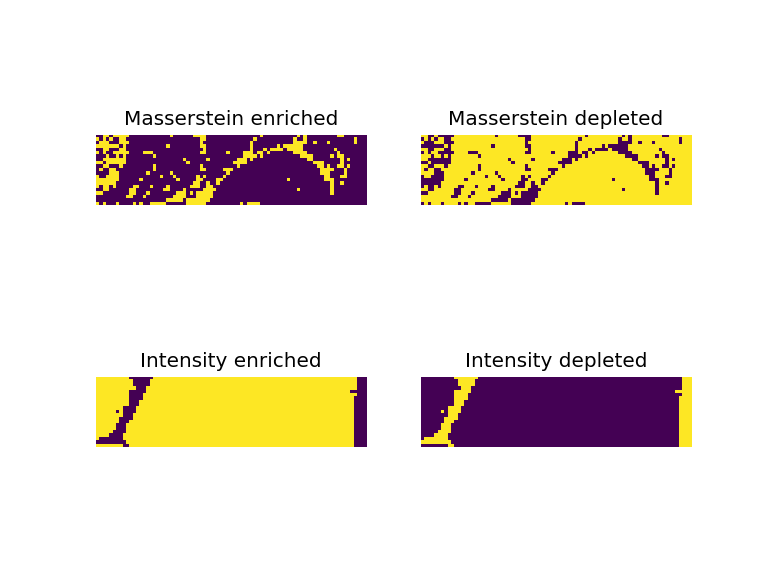

Text(0.5, 1.0, 'Intensity depleted')

In [59]:
plt.figure()
plt.subplot(221)
plt.imshow(masserstein_enrichment)
plt.axis('off')
plt.title('Masserstein enriched')
plt.subplot(222)
plt.imshow(~masserstein_enrichment)
plt.axis('off')
plt.title('Masserstein depleted')
plt.subplot(223)
plt.imshow(intensity_enrichment)
plt.axis('off')
plt.title('Intensity enriched')
plt.subplot(224)
plt.imshow(~intensity_enrichment)
plt.axis('off')
plt.title('Intensity depleted')

In [60]:
masserstein_enriched_spectrum = total_spectrum(profile_images[test_name], 
                                               test_mass_axis, 
                                               masserstein_enrichment)
masserstein_depleted_spectrum = total_spectrum(profile_images[test_name], 
                                               test_mass_axis, 
                                               ~masserstein_enrichment)
intensity_enriched_spectrum = total_spectrum(profile_images[test_name], 
                                               test_mass_axis, 
                                               intensity_enrichment)
intensity_depleted_spectrum = total_spectrum(profile_images[test_name], 
                                               test_mass_axis, 
                                               ~intensity_enrichment)

In [61]:
enrichment_peak_heights = [np.interp(test_lipid_mass, test_mass_axis, intsy) for intsy in [
    masserstein_enriched_spectrum,
    masserstein_depleted_spectrum,
    intensity_enriched_spectrum,
    intensity_depleted_spectrum
]]

In [62]:
enrichment_peak_heights

[200.52078478091235, 609.7880734583009, 806.3705075884176, 3.9383506507947748]

In [63]:
test_lipid_spectrum.confs

[(783.56699857595, 1.0),
 (784.5703534111499, 0.46894551188105565),
 (785.56511734595, 0.07216789559955211),
 (785.57370824635, 0.10739785477630465)]

<IPython.core.display.Javascript object>


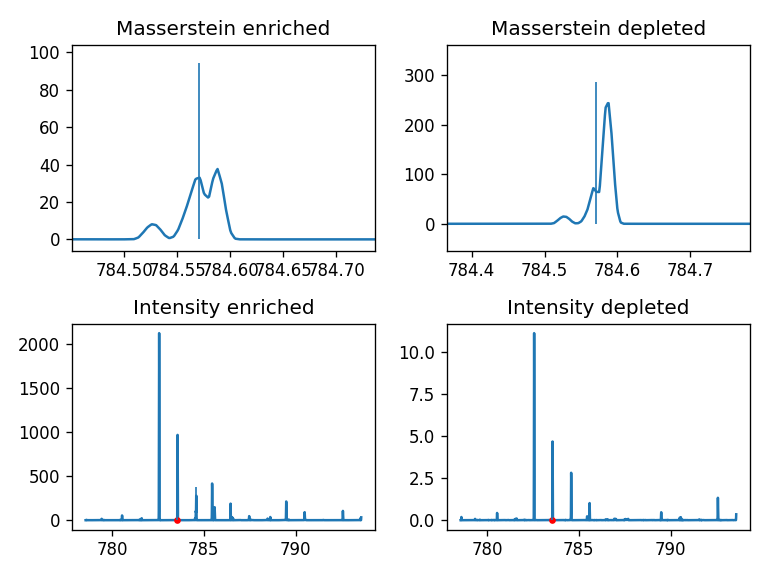

In [64]:
plt.figure()
plt.subplot(221)
plt.plot(test_mass_axis, masserstein_enriched_spectrum)
plt.plot([test_lipid_mass], [0], 'r.')
(test_lipid_spectrum*enrichment_peak_heights[0]).plot()
plt.title('Masserstein enriched')
plt.subplot(222)
plt.plot(test_mass_axis, masserstein_depleted_spectrum)
plt.plot([test_lipid_mass], [0], 'r.')
(test_lipid_spectrum*enrichment_peak_heights[1]).plot()
plt.title('Masserstein depleted')
plt.subplot(223)
plt.plot(test_mass_axis, intensity_enriched_spectrum)
plt.plot([test_lipid_mass], [0], 'r.')
(test_lipid_spectrum*enrichment_peak_heights[2]).plot()
plt.title('Intensity enriched')
plt.subplot(224)
plt.plot(test_mass_axis, intensity_depleted_spectrum)
plt.plot([test_lipid_mass], [0], 'r.')
(test_lipid_spectrum*enrichment_peak_heights[3]).plot()
plt.title('Intensity depleted')
plt.tight_layout()

#### Analysis of cerebellum lipid based on signal enrichment rather than segments

Próba identyfikacji interferencji w 782.567 Da, oraz weryfikacja czy w 783.567 jest rzeczywiście PA

Dofitowac do 4 widm C46H81NO6K C46H81NO6K C42H81NO9K C43H86NO6PK (ACer 46:5;O4, Cer 46:6;O5, HexCer 36:1;O3, CerP 43:1;O2) o masach ~782.5679

In [42]:
candidate_interference_formulas = ['C46H81NO6', 'C42H81NO9', 'C43H86NO6P']  #
# note: C43H85O7P is the test lipid
candidate_interference_spectra = [Spectrum(formula=f, adduct='K', threshold=0.01) for f in candidate_interference_formulas]
for s in candidate_interference_spectra:
    s.normalize()
print([s.confs[0][0] for s in candidate_interference_spectra])

[782.57009583227, 782.55483969287, 782.58298299222]


In [28]:
candidate_test_formulas = ['C50H80O4', 'C43H85O7P', 'C42H85N2O6P']
candidate_test_spectra = [Spectrum(formula=f, adduct='K', threshold=0.01) for f in candidate_test_formulas]
for s in candidate_test_spectra:
    s.normalize()
print([s.confs[0][0] for s in candidate_test_spectra])

[783.5693675554, 783.56699857595, 783.5782319641501]


In [47]:
candidate_cluster_formulas = candidate_interference_formulas + candidate_test_formulas
candidate_cluster_spectra = [Spectrum(formula=f, adduct='K', threshold=0.01) for f in candidate_cluster_formulas]
for s in candidate_cluster_spectra:
    s.normalize()
print([s.confs[0][0] for s in candidate_cluster_spectra])

[782.57009583227, 782.55483969287, 782.58298299222, 783.5693675554, 783.56699857595, 783.5782319641501]


In [53]:
MTD = 0.05
MTD_th = 0.06

# MTD = 0.005
# MTD_th = 0.01

In [54]:
candidate_images = np.zeros(image_shapes['cerebellum'] + (len(candidate_cluster_spectra), ))

n = 'cerebellum'
for idx, (xcoord,ycoord,zcoord) in enumerate(centroided_images[n].coordinates):
    if not idx % 10000:
        print('Processing pixel number', idx)
#         if idx % 10: 
#             continue
    mz, intsy = centroided_images[n].getspectrum(idx)
    total_tic = np.sum(intsy)
    selected_range = (778 <= mz)*(mz <= 800)
    mz = mz[selected_range]
    intsy = intsy[selected_range]
    local_tic = np.sum(intsy)
#         selected_peaks = intsy >= 1e-4*max(intsy)
#         mz = mz[selected_peaks]
#         intsy = intsy[selected_peaks]
    pixel_spectrum = Spectrum(confs=list(zip(mz, intsy)))
    pixel_spectrum.normalize()
    regression = estimate_proportions(pixel_spectrum, candidate_cluster_spectra, 
                                      MTD=MTD, MTD_th=MTD_th, MDC=1e-06, MMD=0.1, progress=False)
    props = np.array(regression['proportions'])
    # We want to rescale the proportions so that it's as if they were calculated 
    # on full spectra (i.e. we correct for restricting spectra to the local mass range)
    rescaled_props = props*local_tic / total_tic 
    candidate_images[ycoord-1, xcoord-1, ...] = rescaled_props


Processing pixel number 0


<IPython.core.display.Javascript object>


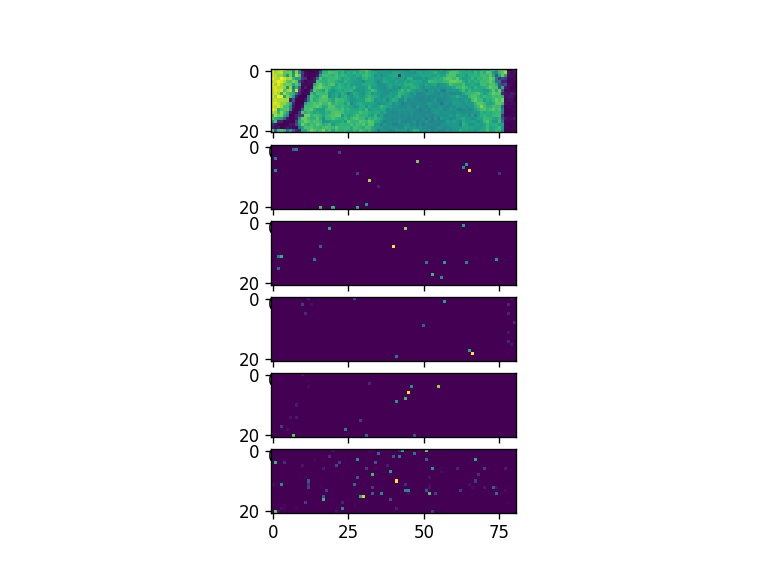

In [55]:
plt.figure()
for i in range(len(candidate_cluster_spectra)):
    plt.subplot(100*len(candidate_cluster_spectra) + 11+i)
    plt.imshow(candidate_images[..., i])

In [33]:
average_spectrum = total_spectrum(profile_images[test_name], 
                                  test_mass_axis)

In [45]:
candidate_peak_heights = [np.interp(s.confs[0][0], test_mass_axis, average_spectrum) for s in candidate_interference_spectra]

<IPython.core.display.Javascript object>


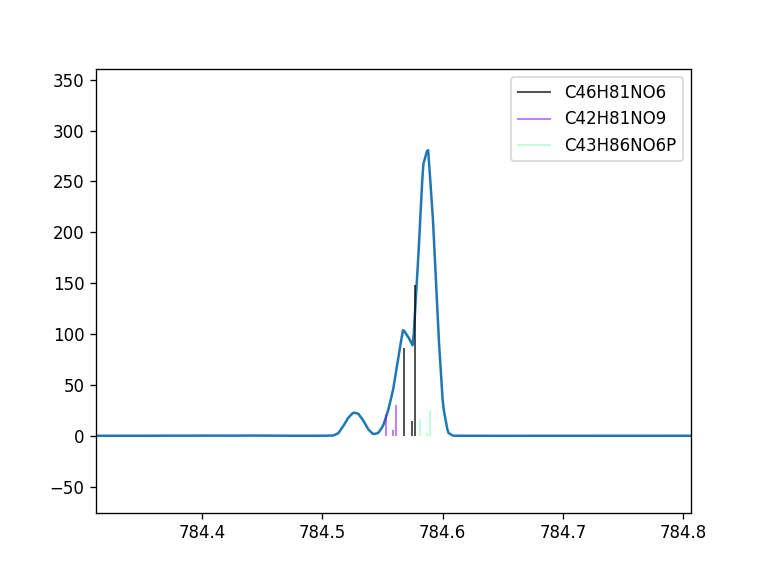

In [46]:
plt.figure()
plt.plot(test_mass_axis, average_spectrum)
Spectrum.plot_all([s*h for s,h in zip(candidate_interference_spectra, candidate_peak_heights)])


In [80]:
test_cluster_spectra = [s for s in lipid_spectra[test_name] if 780 <= s.confs[0][0] <= 787]

In [81]:
[s.confs[0][0] for s in test_cluster_spectra]

[783.56699857595,
 785.45236274437,
 781.56258189961,
 783.5782319641501,
 786.5415121035401,
 784.525862039]